# Load Shedding and Shifting Example

This example is a simple illustration that aims to explain the use of load shedding and load shifting in PyPSA. The example is designed to simulate a single day of electrical consumption in a small network with solar generation, which could represent a single house or a small group of houses.

In [2]:
import pypsa
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

### Create network

In [3]:
network = pypsa.Network()

### Build the snapshots we consider for the first T hours in 2023


In [4]:
network.set_snapshots(pd.date_range("2023-01-01 04:00", "2023-01-01 20:00", freq="H"))

print(network.snapshots)

DatetimeIndex(['2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='H')


### Add fuel types

In [5]:
network.add("Carrier", "solar")
network.add("Carrier", "load")
network.add("Carrier", "battery")

### Add buses

In [6]:
network.add("Bus", "My bus")

### Add generators

Solar PV panel generation per unit of capacity is considered only in the daytime.

"load shedding" is introduced as a generator to illustrate the decrease in demand, thereby enhancing the generation. It is essential when the network's generation is insufficient to fulfill the required demand

In [7]:
# Add solar generation
pv_pu = [
    0.0,
    0.0,
    0.0,
    0.2,
    0.4,
    0.65,
    0.85,
    0.9,
    0.85,
    0.65,
    0.4,
    0.3,
    0.2,
    0.1,
    0.0,
    0.0,
    0.0,
]
network.add(
    "Generator",
    "solar",
    bus="My bus",
    p_nom=0.4,
    carrier="solar",
    p_max_pu=pv_pu,
    marginal_cost=0 + 0.01 * np.random.random(),
)

# Add load shedding as generator
network.add(
    "Generator",
    "load shedding",
    bus="My bus",
    p_nom=50,
    carrier="load",
    p_max_pu=1.0,
    marginal_cost=1e2,
    p_nom_extendable=True,
)

### Add constant base load values

In [8]:
load = pd.Series(0.2, index=range(17))  # constant baseload
network.add("Load", "baseload", bus="My bus", p_set=load.values)

### Add storage units to the network

Storage units could be used to represent load shifting in PyPSA, where energy use is in peak hours is shifted to off-peak hours, which is a similar behaviour to discharging a storage unit in peak hours and charging it in off-peak hours.

Smart thermostats can shift the timing of energy use by automatically reducing heating or cooling during peak demand periods and increasing it during off-peak periods.

In [9]:
network.add(
    "StorageUnit",
    "smart thermostat",
    bus="My bus",
    p_nom=0,
    carrier="battery",
    marginal_cost=4 * np.random.random(),
    p_nom_extendable=True,
    p_max_pu=1,
    p_min_pu=-1,
    efficiency_store=0.9,
    efficiency_dispatch=0.95,
    standing_loss=0.01,
    cyclic_state_of_charge=True,
    max_hours=6,
)

### Optimize the network and plot some results

In [10]:
network.lopf()

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+02


('ok', 'optimal')

Text(0, 0.5, 'Power (MW)')

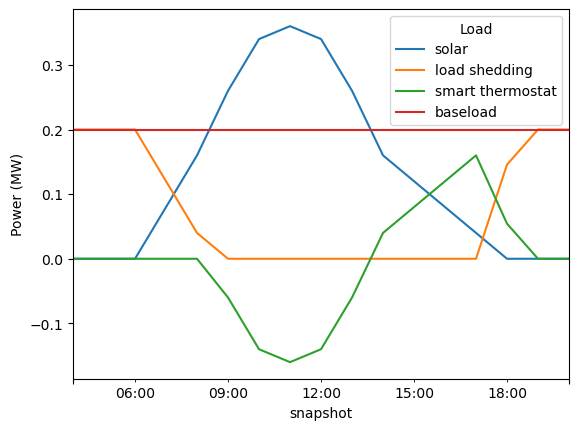

In [11]:
fig, ax = plt.subplots()

network.generators_t.p.plot(ax=ax)
network.storage_units_t.p.plot(ax=ax)
network.loads_t.p.plot(ax=ax)

ax.set_ylabel("Power (MW)")

We can observe from the least cost solution the following:
- The smart thermostat is increasing the demand during the peak solar generation, to save energy when there is a lack of supply
- In the first and last hours of the day, load shedding is applied since there is not enough storage or generation available

In [12]:
network_cost_per_MWh = (network.objective + network.objective_constant) / network.loads_t.p.sum().sum()
new_demand = (network_cost_per_MWh-100)/-300

38.5025255

For simplicity, assuming a linear relationship between price and demand

In [13]:
# Setting up the network while chnging the load
network = pypsa.Network()
network.set_snapshots(pd.date_range("2023-01-01 04:00", "2023-01-01 20:00", freq="H"))
network.add("Carrier", "solar")
network.add("Carrier", "load")
network.add("Carrier", "battery")
network.add("Bus", "My bus")
pv_pu = [0.0,0.0,0.0,0.2,0.4,0.65,0.85,0.9,0.85,0.65,0.4,0.3,0.2,0.1,0.0,0.0,0.0,]
network.add("Generator","solar",bus="My bus",p_nom=0.4,carrier="solar",p_max_pu=pv_pu,
            marginal_cost=0 + 0.01 * np.random.random(),)
network.add("Generator","load shedding",bus="My bus",p_nom=50,carrier="load",p_max_pu=1.0,marginal_cost=1e2,
            p_nom_extendable=True,)
load = pd.Series(0.2, index=range(17))  # constant baseload
network.add("Load", "baseload", bus="My bus", p_set=load.values)
network.add("StorageUnit","smart thermostat",bus="My bus",p_nom=0,carrier="battery",
    marginal_cost=4 * np.random.random(),p_nom_extendable=True,p_max_pu=1,p_min_pu=-1,
    efficiency_store=0.9,efficiency_dispatch=0.95,standing_loss=0.01,cyclic_state_of_charge=True,max_hours=6,)
network.lopf()




INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.1s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+02


('ok', 'optimal')

In [14]:
network2.objective

131.5218149

In [17]:
network.loads_t

{'p_set': Load                 baseload
 snapshot                     
 2023-01-01 04:00:00       0.2
 2023-01-01 05:00:00       0.2
 2023-01-01 06:00:00       0.2
 2023-01-01 07:00:00       0.2
 2023-01-01 08:00:00       0.2
 2023-01-01 09:00:00       0.2
 2023-01-01 10:00:00       0.2
 2023-01-01 11:00:00       0.2
 2023-01-01 12:00:00       0.2
 2023-01-01 13:00:00       0.2
 2023-01-01 14:00:00       0.2
 2023-01-01 15:00:00       0.2
 2023-01-01 16:00:00       0.2
 2023-01-01 17:00:00       0.2
 2023-01-01 18:00:00       0.2
 2023-01-01 19:00:00       0.2
 2023-01-01 20:00:00       0.2,
 'q_set': Empty DataFrame
 Columns: []
 Index: [2023-01-01 04:00:00, 2023-01-01 05:00:00, 2023-01-01 06:00:00, 2023-01-01 07:00:00, 2023-01-01 08:00:00, 2023-01-01 09:00:00, 2023-01-01 10:00:00, 2023-01-01 11:00:00, 2023-01-01 12:00:00, 2023-01-01 13:00:00, 2023-01-01 14:00:00, 2023-01-01 15:00:00, 2023-01-01 16:00:00, 2023-01-01 17:00:00, 2023-01-01 18:00:00, 2023-01-01 19:00:00, 2023-01-01 20:00:

In [15]:

network_cost_per_MWh = 38.83336087757376
new_demand = (network_cost_per_MWh-100)/-300

0.20388879707475413

In [67]:
import pypsa
import pandas as pd
import numpy as np

base_load = 0.2
all_networks = []

for _ in range(6):
    network = pypsa.Network()
    network.set_snapshots(pd.date_range("2023-01-01 04:00", "2023-01-01 20:00", freq="H"))
    network.add("Carrier", "solar")
    network.add("Carrier", "load")
    network.add("Carrier", "battery")
    network.add("Bus", "My bus")
    pv_pu = [0.0, 0.0, 0.0, 0.2, 0.4, 0.65, 0.85, 0.9, 0.85, 0.65, 0.4, 0.3, 0.2, 0.1, 0.0, 0.0, 0.0]
    network.add("Generator", "solar", bus="My bus", p_nom=0.4, carrier="solar", p_max_pu=pv_pu,
                marginal_cost=0 + 0.01 * np.random.random())
    network.add("Generator", "load shedding", bus="My bus", p_nom=50, carrier="load", p_max_pu=1.0, marginal_cost=1e2,
                p_nom_extendable=True)
    load = pd.Series(base_load, index=range(17))  # variable baseload based on base_load_values
    network.add("Load", "baseload", bus="My bus", p_set=load.values)
    network.add("StorageUnit", "smart thermostat", bus="My bus", p_nom=0, carrier="battery",
                marginal_cost=4 * np.random.random(), p_nom_extendable=True, p_max_pu=1, p_min_pu=-1,
                efficiency_store=0.9, efficiency_dispatch=0.95, standing_loss=0.01, cyclic_state_of_charge=True,
                max_hours=6)
    network.lopf()

    network_cost_per_MWh = (network.objective + network.objective_constant) / network.loads_t.p.sum().sum()
    new_load = (network_cost_per_MWh - 120) / -300
    base_load = new_load
    
    all_networks.append(network)


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.44e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.67e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.16e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Glpk s

In [65]:
# Access individual networks using indices in the list
network1 = all_networks[0]
network2 = all_networks[1]
network3 = all_networks[2]
network4 = all_networks[3]
network5 = all_networks[4]

In [74]:
for n in all_networks:
    print(n.loads_t.p.mean().sum(),(n.objective + n.objective_constant) / n.loads_t.p.sum().sum())


0.2 38.900205529411764
0.2703326482352941 53.1231232626334
0.22292292245788867 44.1923095722065
0.2526923014259783 50.207585385091164
0.23264138204969612 46.42589146342842
0.24524702845523857 48.69183750784179


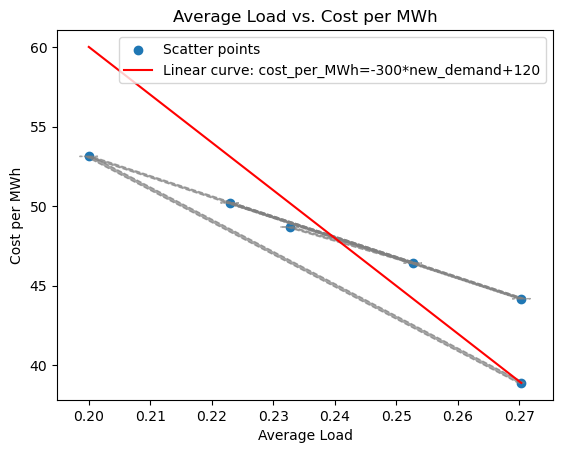

In [75]:
import matplotlib.pyplot as plt
import numpy as np

average_loads = [0.2, 0.2703326482352941, 0.22292292245788867, 0.2526923014259783, 0.23264138204969612, 0.24524702845523857]
costs_per_MWh = [38.900205529411764, 53.1231232626334, 44.1923095722065, 50.207585385091164, 46.42589146342842, 48.69183750784179]

# Shift the values so the first price is associated with the second demand value, and so on
shifted_average_loads = [average_loads[1]] + average_loads[:-1]

# Scatter plot of the points
plt.scatter(shifted_average_loads, costs_per_MWh, label='Scatter points')

# Arrows between the points
for i in range(len(shifted_average_loads) - 1):
    plt.arrow(shifted_average_loads[i], costs_per_MWh[i], shifted_average_loads[i + 1] - shifted_average_loads[i],
              costs_per_MWh[i + 1] - costs_per_MWh[i], linestyle='--', lw=1, color='gray', alpha=0.7)

# Linear curve
x = np.linspace(min(shifted_average_loads), max(shifted_average_loads), 100)
y = -300 * x + 120
plt.plot(x, y, label='Linear curve: cost_per_MWh=-300*new_demand+120', color='red')

plt.xlabel('Average Load')
plt.ylabel('Cost per MWh')
plt.title('Average Load vs. Cost per MWh')
plt.legend()
plt.show()
